# Исследование данных крупного интернет магазина

Вы — аналитик крупного интернет-магазина. Вместе с отделом маркетинга вы подготовили список гипотез для увеличения выручки.

Данные мы получим из трех файлов: файл hypothesis.csv хранит 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort, orders.csv — информацию о заказах, а visitors.csv — информацию о группах пользователей A/B-теста. 

Исследование пройдет в 5 этапов:
1. Обзор данных.
2. Предобработка данных.
3. Исследовательский анализ данных.
4. Приоритизация гипотез.
5. Анализ результатов A/B-теста.

### Обзор данных

In [1]:
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt

try:
    hypothesis = pd.read_csv('/datasets/hypothesis.csv', sep=',')
except:
    hypothesis = pd.read_csv(r'C:\Users\asus\Downloads\hypothesis.csv', sep=',')
    
try:
    orders = pd.read_csv('/datasets/orders.csv', sep=',')
except:
    orders = pd.read_csv(r'C:\Users\asus\Downloads\orders.csv', sep=',')
    
try:
    visitors = pd.read_csv('/datasets/visitors.csv', sep=',')
except:
    visitors = pd.read_csv(r'C:\Users\asus\Downloads\visitors.csv', sep=',')

pd.options.display.max_colwidth = 110    

display(orders.head(10))
display(visitors.head(10)) 

(hypothesis
.style
.background_gradient(subset=['Reach','Impact','Confidence','Efforts'], cmap='RdPu'))

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B
6,398296753,2900797465,2019-08-15,1860,B
7,2626614568,78758296,2019-08-15,1044,A
8,1576988021,295230930,2019-08-15,13710,A
9,1506739906,1882260405,2019-08-15,1855,B


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
5,2019-08-06,A,667
6,2019-08-07,A,644
7,2019-08-08,A,610
8,2019-08-09,A,617
9,2019-08-10,A,406


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


### Предобработка данных

Сделаем предобработку таблицы hypothesis:

In [2]:
hypothesis.columns = hypothesis.columns.str.lower() # приведем названия колонок к нижнему регистру
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   hypothesis  9 non-null      object
 1   reach       9 non-null      int64 
 2   impact      9 non-null      int64 
 3   confidence  9 non-null      int64 
 4   efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


На этапе обзора данных мы увидели, что дубликатов и пропусков в данной таблице нет, с типами данных ошибок так же не возникло.

Сделаем предобработку таблицы orders:

In [3]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


Поменяем тип столбца "date" на datetime:

In [4]:
orders["date"] = orders["date"].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

Посчитаем количество пропусков и дубликатов:

In [5]:
print(orders.isna().sum()) # посчитаем количество пропусков в столбцах
print('Количество явных дубликатов:',orders.duplicated().sum()) # подсчёт явных дубликатов

transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64
Количество явных дубликатов: 0


В таблице orders пропусков и дубликатов не оказалось. Тип столбца 'date' мы заменили на datetime, так как в нем содержится информация о дате.

Сделаем предобработку таблицы visitors:

In [6]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


Поменяем тип столбца "date" на datetime

In [7]:
visitors["date"] = visitors["date"].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

Посчитаем количество пропусков и дубликатов:

In [8]:
print(visitors.isna().sum()) # посчитаем количество пропусков в столбцах
print('Количество явных дубликатов:',visitors.duplicated().sum()) # подсчёт явных дубликатов

date        0
group       0
visitors    0
dtype: int64
Количество явных дубликатов: 0


В таблице visitors пропусков и дубликатов не оказалось. Тип столбца 'date' мы так же заменили на datetime.

На этапе преобработки мы проверили таблицы на наличие пропусков и дубликатов. И заменили тип данных в столбцах, содержащих информацию о дате, на datetime.

### Исследовательский анализ данных

Определим, сколько групп в A/B тесте:

In [9]:
print(orders['group'].unique())

['B' 'A']


Логично, в A/B тесте только 2 группы - A и B.

Определим, сколько пользователей в каждой группе:

In [10]:
print(orders.groupby('group')['visitorId'].count())

group
A    557
B    640
Name: visitorId, dtype: int64


В группе A - 557 пользователей, в группе B - 640 пользователей.

Определим, не попадают ли какие-то пользователи в обе группы:

In [11]:
print(orders.groupby('visitorId').agg({'group' : 'nunique'}).query('group>1').count())

visitors_two_groups = orders.groupby('visitorId').agg({'group' : 'nunique'}).reset_index().query('group>1')['visitorId'].unique()

orders = orders.query('visitorId not in @visitors_two_groups')

group    58
dtype: int64


Оказалось, что 58 пользователей попали в две группы теста - это говорит об ошибке в сборе данных. Мы можем исключить этих пользователей из таблицы с заказами, но не сможем удалить из таблицы с визитами, так как данные в этом датасете агрегированы; удаление этих пользователей повляет на конверсию. Поэтому мы удалили их только из таблицы с заказами. 

На этапе исследовательского анализа данных мы определили, сколько групп в тесте и сколько пользователей в каждой группе. Так же мы определили сколько пользователей попадают в обе группы и удалили этих пользователей из таблицы orders. 

### Приоритизация гипотез

Применим фреймворк ICE для приоритизации гипотез. Отсортируем их по убыванию приоритета.
Будем использовать формулу: $$ICE = \frac{Impact * Confidence}{Efforts}$$

In [12]:
hypothesis['ICE']=hypothesis['impact']*hypothesis['confidence']/hypothesis['efforts']

(hypothesis[['hypothesis','ICE']].sort_values(by='ICE',ascending=False)
.style
.background_gradient(subset=['ICE'], cmap='RdPu'))

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000


Наиболее перспективные гипотезы по ICE: 8, 0, 7, 6, 2

Применим фреймворк RICE для приоритизации гипотез. Отсортируем их по убыванию приоритета. Будем использовать формулу:
$$RICE = \frac{Reach * Impact * Confidence}{Efforts}$$

In [13]:
hypothesis['RICE']=hypothesis['reach']*hypothesis['impact']*hypothesis['confidence']/hypothesis['efforts']

(hypothesis[['hypothesis','RICE']].sort_values(by='RICE',ascending=False)
.style
.background_gradient(subset=['RICE'], cmap='RdPu'))

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.000000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.000000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.000000
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.000000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.000000


Наиболее перспективные гипотезы по RICE: 7, 2, 0, 6, 8

При применении RICE вместо ICE наиболее перспективными гипотезами так же остались 8, 0, 7, 6, 2; но 7 гипотеза стала наиболее перспективной, а 8, которая была на первом месте, переместилась на 5 место по приоритизации. 

"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок" - эта гипотеза занимает первое место по параметру Reach, так как ее влияние дейcтвительно затронет большое количество пользователей, но не на всех она окажет сильное влияние (всем будет предложена форма подписки, но только 70% клиентов ее заполнят). Поэтому по RICE она занимает первое место, а по ICE - третье.

"Запустить акцию, дающую скидку на товар в день рождения" - влияние данной гипотезы затронет минимальное количество пользователей, но изменения сильно повлиюят на пользователей (действительно, скидки в день рождения сильно повышают спрос на товар). Поэтому по RICE она занимает пятое место, а по ICE - первое.

"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей" - данная гипотеза стала ниже на одну строку по RICE, так как по охвату значение не самое высокое (30%), но влияние у нее максимальное (100%). Поэтому по RICE она занимает третье место, а по ICE - второе.

"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию" - эта гипотеза так и осталась на 4 месте по обоим способам приоритизации.

"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа" - данная гипотеза поднялась 3 строки вверх по приоритизации, так как охват пользователей у нее достаточно большой (80%), но вот влияние она оказывает невысокое (30%). Поэтому по RICE она занимает второе место, а по ICE - пятое.

### Анализ A/B-теста

Построим график кумулятивной выручки по группам.

In [14]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates() 

# получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'transactionId' : 'nunique', 'visitorId' : 'nunique', 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

print(cumulativeData.head(5)) 

        date group  orders  buyers  revenue  visitors
0 2019-08-01     A      23      19   142779       719
1 2019-08-01     B      17      17    59758       713
2 2019-08-02     A      42      36   234381      1338
3 2019-08-02     B      40      39   221801      1294
4 2019-08-03     A      66      60   346854      1845


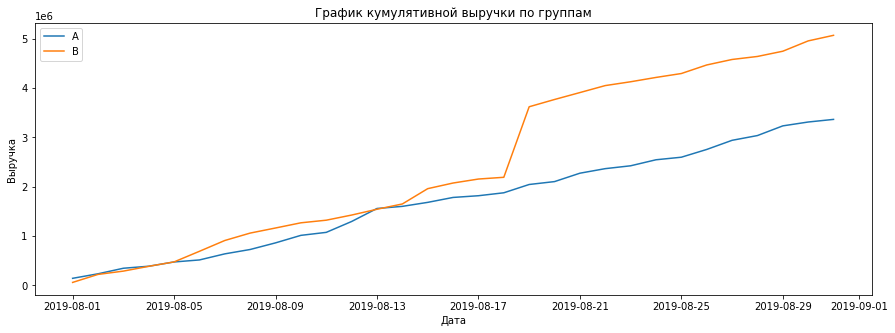

In [15]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

plt.figure(figsize=(15,5))
# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.title("График кумулятивной выручки по группам")
plt.xlabel("Дата")
plt.ylabel("Выручка")
plt.legend()
plt.show()

Выручка почти равномерно увеличивается в течение теста у обеих групп. Но у группы B в одной точке резко возрастает (видимо было увеличение числа заказов или появление более дорогих заказов в выборке).  

Построим график кумулятивного среднего чека по группам. 

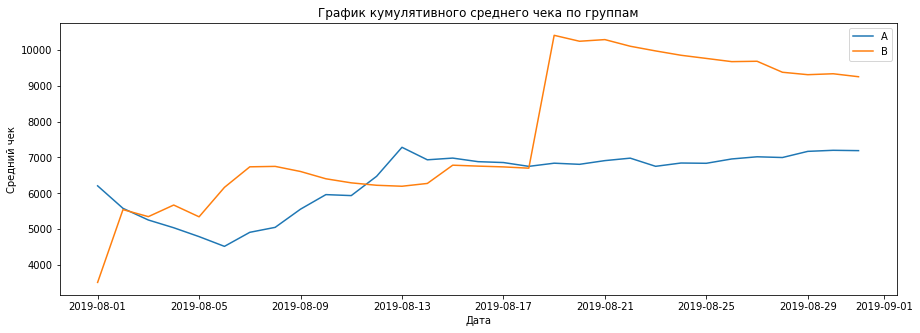

In [16]:
plt.figure(figsize=(15,5))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')

plt.title("График кумулятивного среднего чека по группам")
plt.xlabel("Дата")
plt.ylabel("Средний чек")
plt.legend() 
plt.show()

В первой половине теста у обеих групп наблюдается неравномерный средний чек. У группы B он возрастает с несколькими выбросами вниз, а у группы A присутствет один сильный выброс вниз почти в начале теста, а далее средний чек начинает возрастать. Средний чек у обеих групп становится равномерным только после середины теста: у группы B после сильного скачка начал падать, а у группы A установился и даже немного возрастает. Видимо, в группе B в начале второй половины теста попали крупные заказы. 

Построим график относительного изменения кумулятивного среднего чека группы B к группе A.

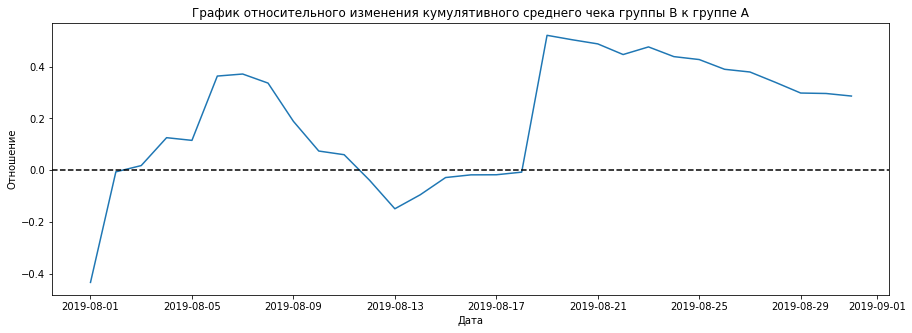

In [17]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(15,5))
# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--') 
plt.title("График относительного изменения кумулятивного среднего чека группы B к группе A")
plt.xlabel("Дата")
plt.ylabel("Отношение")
plt.show()

Средний чек группы B сначала возрастал (вскоре превысил средний чек группы A) с одним небольшим скачок вниз, а примерно 7-8 августа начал сильно падать, и даже стал ниже среднего чека группы A. Падение происходило до 13 августа, далее средний чек группы B снова начал расти (и вскоре снова превысил средний чек группы A, и до конца месяца оставался больше, чем у группы A). Примерно 18-19 числа произошел сильный рост выручки группы B, а после начал снижаться.

Построим график кумулятивного среднего количества заказов на посетителя по группам. 

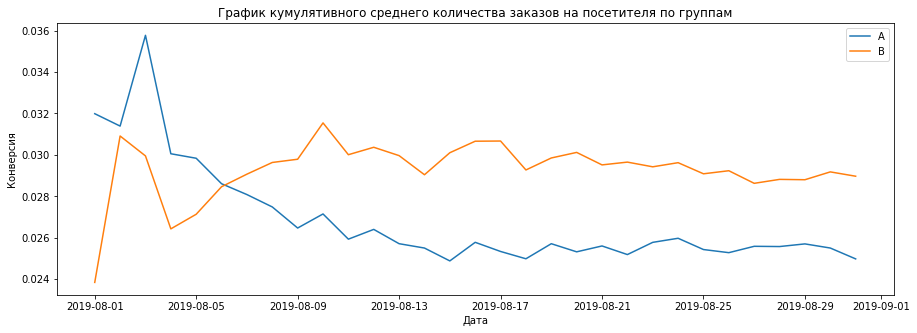

In [18]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

plt.figure(figsize=(15,5))
# строим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()

plt.title("График кумулятивного среднего количества заказов на посетителя по группам")
plt.xlabel("Дата")
plt.ylabel("Конверсия")
plt.show()

В начале месяца конверсия сильно колебалась у обеих групп, но затем конверсия группы B возросла и зафиксировалась, сильно опережаю группу A, а конверсия группы A сильно снизилась и также зафиксировалась.

Построим график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A. 

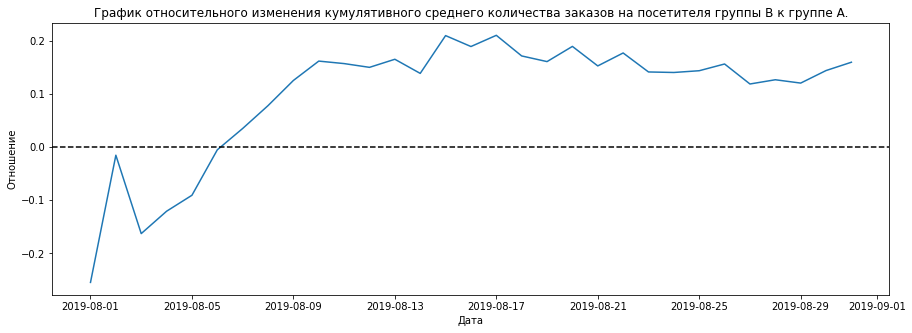

In [19]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(15,5))
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1)

plt.axhline(y=0, color='black', linestyle='--')
plt.title("График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A.")
plt.xlabel("Дата")
plt.ylabel("Отношение")
plt.show()

В начале теста группа B проигрывала группе A по количеству заказов, затем ее конверсия выросла и превысила конверсию группы A (уже до конца месяца), и в среднем оставалась примерно на одном уровне.

Построим точечный график количества заказов по пользователям.

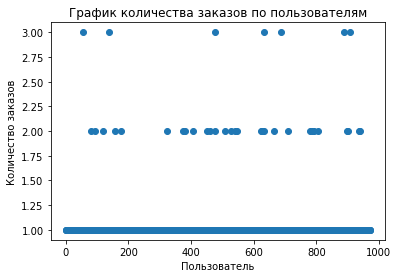

In [20]:
ordersByUsers = (
    orders.groupby('visitorId', as_index=False)
    .agg({'transactionId': 'nunique'})
)

ordersByUsers.columns = ['visitorId', 'orders'] 

x_values = pd.Series(range(0,len(ordersByUsers)))

plt.scatter(x_values, ordersByUsers['orders']) 
plt.title("График количества заказов по пользователям")
plt.xlabel("Пользователь")
plt.ylabel("Количество заказов")
plt.show()

Большинство пользователей делали заказ только один раз. Так же достаточно много пользователей с 2 заказами. Но присутствуют и пользователи, которые совершали 3 заказа в неделю. 

Посчитаем 95-й и 99-й перцентили количества заказов на пользователя.

In [21]:
print(np.percentile(ordersByUsers['orders'], [95, 99])) 

[1. 2.]


Не более 1% пользователей оформляли больше чем 2 заказа. И 5% пользователей заказывали более одного раза. 
Выберем 2 заказа на одного пользователя за верхнюю границу числа заказов, и отсеим аномальных пользователей по ней.

Построим точечный график стоимостей заказов. 

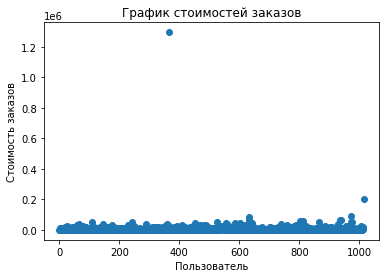

In [22]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue']) 

plt.title("График стоимостей заказов")
plt.xlabel("Пользователь")
plt.ylabel("Стоимость заказов")
plt.show()

В большинстве случаев цены заказов находятся в диапазоне до 100 000 рублей. Но заказ с самой максимальной ценой составляет более 1 200 000 рублей. Так же есть заказ около 200 000 рублей. Такие дорогие заказы следует удалить из теста, так как если такой заказ попадет в одну из групп теста, сразу же сделает ее победителем, исказив результаты. 

Посчитаем 95-й и 99-й перцентили стоимости заказов.

In [23]:
print(np.percentile(orders['revenue'], [95, 99])) 

[26785. 53904.]


Не более 5% заказов дороже 26 785 рублей и не более 1% дороже 53 904 рублей. Выберем 30 000 за заказ за верхнюю границу числа заказов, и отсеим аномальные заказы по ней.

Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным.

Для начала подготовим данные:

In [24]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

Соеберем все данные в одну таблицу:

In [25]:
data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

display(data.head(5)) 

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,23,142779,17,59758,23,142779,17,59758,719,713,719,713
1,2019-08-02,19,91602,23,162043,42,234381,40,221801,619,581,1338,1294
2,2019-08-03,24,112473,14,67049,66,346854,54,288850,507,509,1845,1803
3,2019-08-04,11,41176,14,96890,77,388030,68,385740,717,770,2562,2573
4,2019-08-05,22,86383,21,89908,99,474413,89,475648,756,707,3318,3280


Для начала сформулируем гипотезы. Нулевая: различий в среднем количестве заказов между группами нет. Альтернативная: различия в среднем количестве заказов между группами есть.
Пороговое значение alpha примем равным 0.05.

In [26]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitorId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitorId', 'orders'] 

sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

print("p-value = {0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB, alternative="two-sided")[1]))

print("Относительный показатель 'B' и 'A' = {0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

p-value = 0.011
Относительный показатель 'B' и 'A' = 0.160


P-value = 0.011, что меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в среднем числе заказов между группами нет, отвергаем. По «сырым» данным различия в среднем числе заказов групп A и B есть. Oтносительный выигрыш группы B по отношению к группе A равен 16%.

Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Cформулируем гипотезы. Нулевая: различий в среднем чеке заказа между группами нет. Альтернативная: различия в среднем чеке заказа между группами есть.
Пороговое значение alpha примем равным 0.05.

In [27]:
print("p-value = {0:.3f}".format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'], alternative="two-sided")[1]))
print("Относительный показатель 'B' и 'A' = {0:.3f}".format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

p-value = 0.829
Относительный показатель 'B' и 'A' = 0.287


P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. Но средний чек группы B значительно выше среднего чека группы A, почти на 29%.

Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным. Cформулируем гипотезы. Нулевая: различий в среднем количестве заказов между группами нет. Альтернативная: различия в среднем количестве заказов между группами есть.
Пороговое значение alpha примем равным 0.05. 

In [28]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 2]['visitorId'],
        ordersByUsersB[ordersByUsersB['orders'] > 2]['visitorId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 30000]['visitorId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head(5))
print(abnormalUsers.shape[0]) 

1099    148427295
928     204675465
33      249864742
684     358944393
648     382846391
Name: visitorId, dtype: int64
49


Всего 49 аномальных пользователей. 

In [29]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitorId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitorId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 

print("p-value = {0:.3f}".format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered, alternative="two-sided")[1]))
print("Относительный показатель 'B' и 'A' = {0:.3f}".format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

p-value = 0.010
Относительный показатель 'B' и 'A' = 0.187


 Результаты по среднему количеству заказов почти не изменились. P-value стал равным 0.010, что так же меньше 0.05. Поэтому нулевую гипотезу по прежнему отвергаем. Oтносительный выигрыш группы B по отношению к группе A стал равным 18.7%.

Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Cформулируем гипотезы. Нулевая: различий в среднем чеке заказа между группами нет. Альтернативная: различия в среднем чеке заказа между группами есть.
Пороговое значение alpha примем равным 0.05.

In [30]:
print(
    "p-value = {0:.3f}".format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            alternative="two-sided"
        )[1]
    )
)

print(
    "Относительный показатель 'B' и 'A' = {0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
) 

p-value = 0.741
Относительный показатель 'B' и 'A' = -0.027


P-value значительно увеличился по сравнению с сырыми данными, и даже стал выше порогового значения. Но и разница между сегментами сократилась примерно на 31%. А вот средний чек группы B оказался почти на 3% ниже среднего чека группы A, в то время как по "сырым" данным он был на 29% выше.

### Вывод 
Имеющиеся факты:

Есть статистически значимое различие по среднему количеству заказов между группами и по «сырым», и по данным после фильтрации аномалий; нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий;

Результаты группы A по среднему количеству заказов хуже группы B и по «сырым», и по «очищенным» данным. А вот результаты группы B по среднему чеку по «сырым» данным лучше группы A (не следует учитывать это, так как такой результат получился как раз таки из-за большого аномального значения более чем в 1,2 млн.). По «очищенным» данным средний чек группы B оказался почти на 3% ниже среднего чека группы A.

Исходя из обнаруженных фактов, тест следует остановить и зафиксировать победу группы B. У группы B конверсия гораздо выше, чем у группы A, хотя по среднему чеку группа A немного опережает группу B (менее, чем на 3%). 